In [1]:
%load_ext autoreload
%autoreload 2

## Imports

### Libraries

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary
from torch.optim import lr_scheduler
from torch import optim
import copy
from datetime import time
import wandb
import os

### Custom

In [3]:
from cv_geoguessr.grid.grid_partitioning import Partitioning
from cv_geoguessr.utils.plot_images import plot_images
from cv_geoguessr.utils.evaluation import create_confusion_matrix
from cv_geoguessr.data.data_loader import get_data_loader
from cv_geoguessr.data.data_loader import preview_images
from cv_geoguessr.network.training import train_model
from cv_geoguessr.network.model import load_model
from cv_geoguessr.network.model import lock_layers


## Colab specific

Run only when using Colab.

In [4]:
COLAB = False

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')


## Model constants

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

SAMPLES_TO_SHOW = 5

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=device)
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225], device=device)

CITY_BOUNDS_FILE = '../data/metadata/city bounds/london.csv'

COLAB_LONDON_PHOTO_DIR = lambda train: f'/content/drive/MyDrive/Documents/University/2021-2022/CS4245 Computer Vision/data/images/{"train" if train else "test"}/london'
LOCAL_LONDON_PHOTO_DIR = lambda train: f'../data/images/london/{"train" if train else "test"}'
GCLOUD_LONDON_PHOTO_DIR = lambda train: f'../data/images/{"train" if train else "test"}/'

LONDON_PHOTO_DIR = GCLOUD_LONDON_PHOTO_DIR

# SESSION = wandb.run.name
# BASE_FOLDER = "./checkpoints"
# CHECKPOINT_FOLDER = f'{BASE_FOLDER}/{SESSION}/'

Device: cuda:0


In [5]:
config = {
    "train_batch_size": 32,
    "test_batch_size": 100,
    "cell_width": 0.01,
    "voronoi": True,
    "lr": 0.001,
    "momentum": 0.9,
    "gamma": 0.1,
    "lr_decay_step": 7,
    "epochs": 15,
    "lock_factor": 0.8 # How much of the layers are locked 1 for every thing 0 for training the whole model
}

### Set up grid partitioning

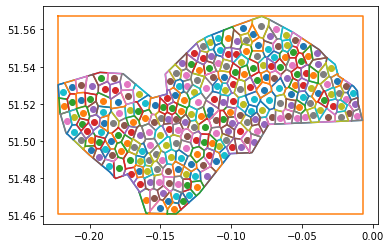

In [6]:
grid_partitioning = Partitioning(CITY_BOUNDS_FILE,
                                 cell_width=config["cell_width"],
                                 voronoi=config["voronoi"])
config["number_of_grid_elements"] = len(grid_partitioning)
grid_partitioning.plot()

### Create the data loaders

In [7]:
data_loaders, data_set_sizes = get_data_loader(LONDON_PHOTO_DIR, grid_partitioning,
                                               config["train_batch_size"],
                                               config["test_batch_size"],
                                               IMAGENET_MEAN,
                                               IMAGENET_STD)

## Train on the grid output


In [11]:
def setup_and_train():
    with wandb.init(project="CV-GeoGuessr", entity="cv-geoguessr", config={**config}) as run:
        wandbconfig = wandb.config

        SESSION = wandb.run.name
        BASE_FOLDER = "./checkpoints"
        CHECKPOINT_FOLDER = f'{BASE_FOLDER}/{SESSION}/'

        # Create the model and lock the layers
        resnet50 = models.resnet50(pretrained=True, progress=True)
        resnet50.fc = nn.Linear(resnet50.fc.in_features, wandbconfig["number_of_grid_elements"])
        resnet50.to(device)
        resnet50 = lock_layers(resnet50, (3, 224, 224), wandbconfig["lock_factor"])

        # create the checkpoint folder and save the untrained model
        if not os.path.isdir(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        torch.save(resnet50.state_dict(), CHECKPOINT_FOLDER + "0.ckpt")

        # Define the criterion, optimizer and exp_lr_scheduler
        criterion = nn.CrossEntropyLoss()
        optimizer_ft = optim.SGD(resnet50.parameters(), lr=wandbconfig["lr"], momentum=wandbconfig["momentum"])
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=wandbconfig["lr_decay_step"], gamma=wandbconfig["gamma"])

        # Train the model
        resnet50 = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler, data_loaders,
                       data_set_sizes, grid_partitioning, CHECKPOINT_FOLDER, device, num_epochs=config["epochs"])

In [12]:
criterion = nn.CrossEntropyLoss()

output = torch.randn(10, 120).float()
target = torch.FloatTensor(10).uniform_(0, 120).long()

loss = criterion(output, target)
print(output.shape)
print(target)

torch.Size([10, 120])
tensor([ 21,  94,  49, 118,  30, 117,  38, 113,  68,  80])


In [16]:
setup_and_train()

255/317 params locked
Epoch 0/14
----------


KeyboardInterrupt: 

In [ ]:
sweep_config = {
  "name" : "unlock_sweep",
  "method" : "bayes",
  "metric" : {
      "name" : "test_reward",
      "goal" : "maximize"
  },
  "parameters" : {
    "lock_factor": {
        "min" : 0.0,
        "max" : 1.0,
    },
    "lr": {
        "min" : 0.0005,
        "max" : 0.005,
    },
    "momentum": {
        "min" : 0.7,
        "max" : 1.0,
    },
    "gamma": {
        "min" : 0.0,
        "max" : 0.5,
    },
    "lr_decay_step": {
        "min" : 2,
        "max" : 20,
    },
  }
}


sweep_id = wandb.sweep(sweep_config, project="CV-GeoGuessr", entity="cv-geoguessr")

count = 10 # number of runs to execute
wandb.agent(sweep_id, function=setup_and_train, count=count, project="CV-GeoGuessr", entity="cv-geoguessr")

Create sweep with ID: zyebr13j
Sweep URL: https://wandb.ai/cv-geoguessr/CV-GeoGuessr/sweeps/zyebr13j


wandb: Agent Starting Run: icdc9r03 with config:
wandb: 	gamma: 0.290528273799875
wandb: 	lock_factor: 0.7773200229827332
wandb: 	lr: 0.001504108342842987
wandb: 	lr_decay_step: 19
wandb: 	momentum: 0.7529521478563596
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


243/317 params locked
Epoch 0/14
----------


In [43]:
# # only works if the loaded model has the same output as the current model
# MODEL_TO_LOAD_PATH = BASE_FOLDER + "/second_test/epoch_24.ckpt"
# resnet50 = load_model(resnet50, MODEL_TO_LOAD_PATH, config["lock_factor"], device)

RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([16, 2048]) from checkpoint, the shape in current model is torch.Size([252, 2048]).
	size mismatch for fc.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([252]).

In [ ]:
# now train with the loaded model with more layers unlocked

# optimizer_ft = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)
# resnet50 = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=config["epochs"])


In [ ]:
confusion_matrix = create_confusion_matrix(resnet50, grid_partitioning, data_loaders['val'], False, device)
print(confusion_matrix.to('cpu'))

In [ ]:
from cv_geoguessr.utils.plot_results import plot_confusion_matrix

plot_confusion_matrix(confusion_matrix)